# Notebook for optimising smFISH analysis parameters
## Using Big-fish v0.6
## Revised: 2023.02.20
1. Optimise Bigfish parameters for a single image
2. The set parameters should then be used for batch processing

In [ ]:
# Environment
import os
import time
from skimage.morphology import white_tophat, black_tophat, disk
from scipy import ndimage, misc
import numpy as np
import tifffile
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import pandas as pd

: 

In [1]:
import os
import bigfish
import bigfish.stack as stack
import bigfish.multistack as multistack 
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


### Make sure the bigfish version is 0.4.0

In [2]:
bigfish.__version__

'0.4.0'

# 0. Load Bigfish helper functions

In [3]:
## Calculate PSF
def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()
    return psf_z, psf_yx

## Subtract background
def subtract_background(image, radius=5, light_bg=False):
    str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
    if light_bg:
        return black_tophat(image, str_el)
    else:
        return white_tophat(image, str_el)

# 1. Import image and its metadata

In [72]:
# Import image file
indir = '../../../../Docum'
file_name = '.tiff'

# img = tifffile.imread(os.path.join(indir, file_name))
img = tifffile.imread(indir)
print("Image imported: ", os.path.join(indir, file_name))
print("\r shape: {0}".format(img.shape))
print("\r dtype: {0}".format(img.dtype))

# Set up image acquisition parameters
chan = 3
voxel_size_z = 200
voxel_size_yx = 65
Ex = 570
Em = 610
NA = 1.45
RI = 1.45
microscope = 'confocal'

psf_z = calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope)[0]
psf_yx = calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope)[1]
sigma_z, sigma_yx, sigma_yx = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
sigma = (sigma_z, sigma_yx, sigma_yx)

print("PSF and Sigma calculation finished")
print("psf_z = ", psf_z)
print("psf_yx = ", psf_yx)
print("sigma_z = ", sigma_z)
print("sigma_yx = ", sigma_yx)

Image imported:  ../../../kate_smfish/rep3/20221221_221221_smFISH_WT_HIV_rep3_72hpi_002.tiff/.tiff
 shape: (41, 4, 2048, 2048)
 dtype: uint16
PSF and Sigma calculation finished
psf_z =  224.03449989716577
psf_yx =  64.62533650879783
sigma_z =  1.1201724994858289
sigma_yx =  0.9942359462891974


# 2. Optimise bigfish parameters
## 2-1. Get LoG filtred RNA channel image for pre-detection tresholding

In [73]:
# Background subtract RNA image and LoG filter
start_time = time.time()

# Channel subset original image
rna = np.swapaxes(img,0,1)[chan]

print("Image shape ")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

# MIP image for plotting later or for 2D detection
rna_mip = stack.maximum_projection(rna)

# Background subtract
rna_no_bg = []
for z in rna:
    z_no_bg = subtract_background(z)
    rna_no_bg.append(z_no_bg)
rna = np.array(rna_no_bg)

print ("Background subtraction finished ", time.time() - start_time, "sec")

# LoG filter
rna_log = stack.log_filter(rna, sigma)
print ("LoG filter finished ", time.time() - start_time, "sec")

# Export LoG filtered image to the working directory
rna_log_max = np.max(rna_log, 0)
im = Image.fromarray(rna_log_max)
im.save('rna_log.tif') # how to add channel name from config to this image filename?

print ("Image saved to working dir! Open it on ImageJ! ", time.time() - start_time, "sec")


Image shape 
 shape: (41, 2048, 2048)
 dtype: uint16
Background subtraction finished  17.290452003479004 sec
LoG filter finished  81.85486626625061 sec
Image saved to working dir! Open it on ImageJ!  82.09429025650024 sec


## 2-2 Optimise single-spot detection

pre-detect done
threshold done 13.567946910858154 sec
detected spots
 shape: (18007, 3)
 dtype: int64
 threshold: 15


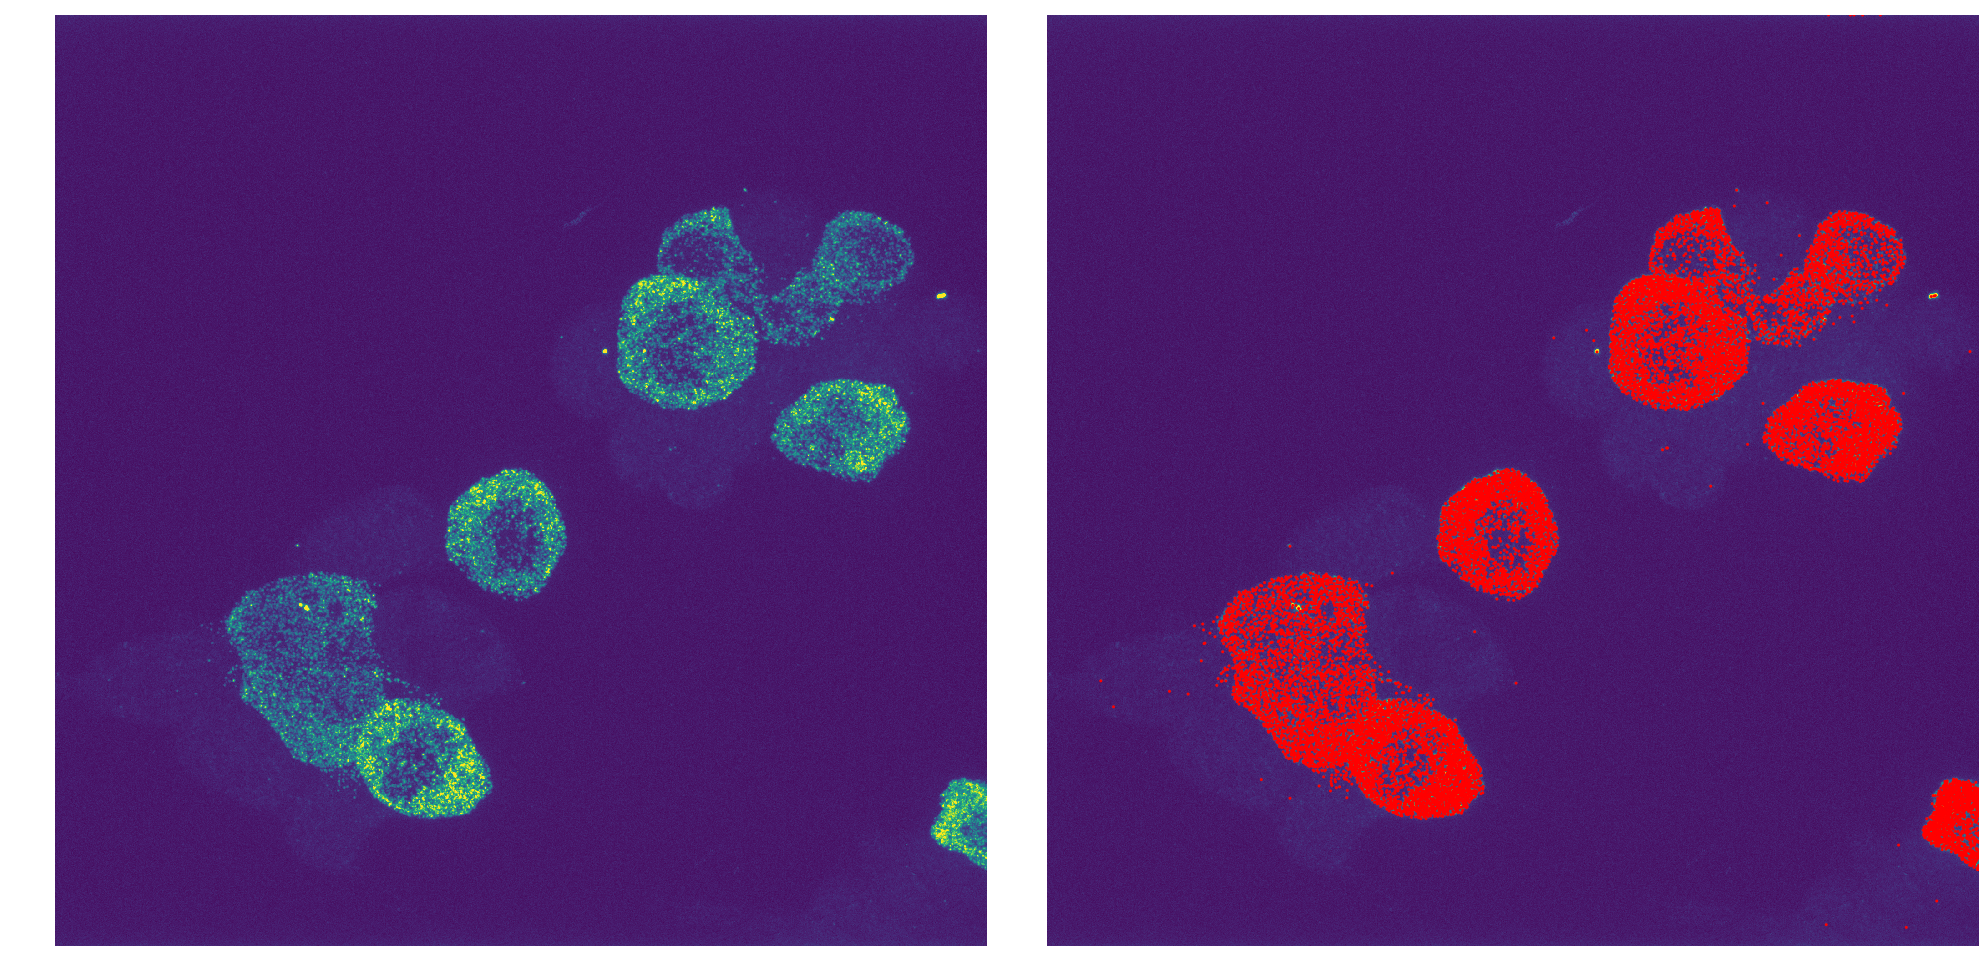

Plotting done  37.233816146850586 sec


In [74]:
## local maximum detection
start_time = time.time()

mask = detection.local_maximum_detection(rna_log, min_distance=sigma)
print ('pre-detect done')

## thresholding
threshold = 15
spots, _ = detection.spots_thresholding(rna_log, mask, threshold)
print ('threshold done', time.time() - start_time, "sec")

print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("\r threshold: {0}".format(threshold))

# Optional plotting
import bigfish.plot as plot

image_contrasted = stack.rescale(rna, channel_to_stretch=0)
image_contrasted = stack.maximum_projection(image_contrasted)

(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
plot.plot_detection(rna_mip, spots, radius=radius_yx, framesize=(20, 16), contrast=True)

print ("Plotting done ", time.time() - start_time, "sec")

## 2-3. Decompose cluster

### 2-3-1. Get a reference spot

Denoising done  21.042722940444946 sec
Denoised reference spot for decompose cluster 21.11571192741394 sec
 shape: (5, 5, 5)
 dtype: uint16


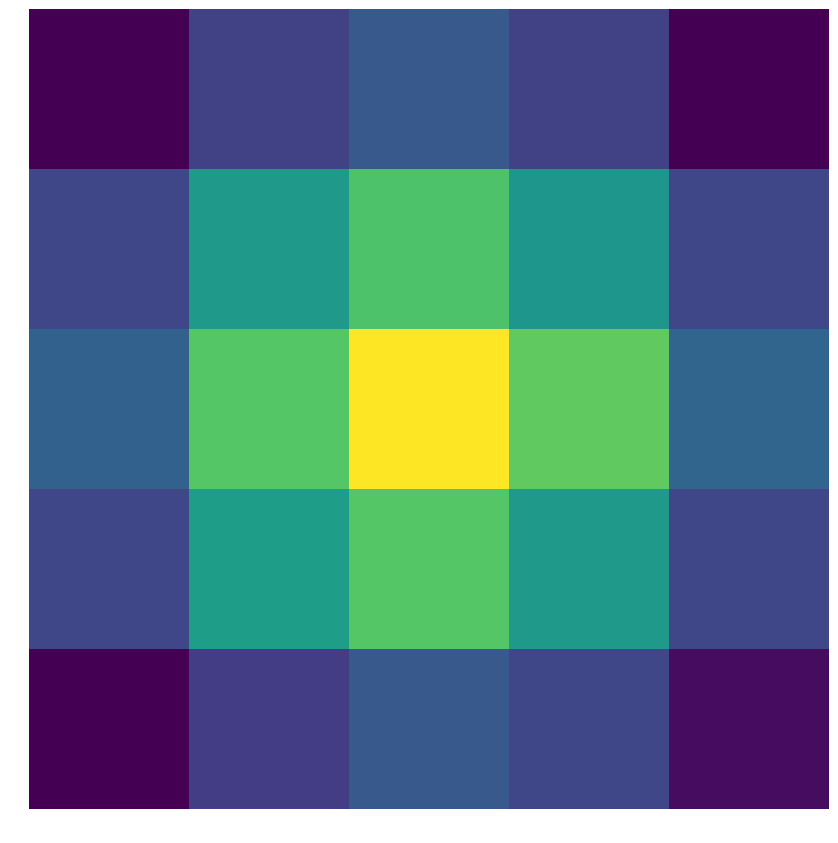

In [41]:
# sigma
start_time = time.time() 

sigma = detection.get_sigma(voxel_size_z, voxel_size_yx, psf_z, psf_yx)
large_sigma = tuple([sigma_ * 5 for sigma_ in sigma])

# denoising
rna_denoised = stack.remove_background_gaussian(rna, large_sigma)

print ("Denoising done ", time.time() - start_time, "sec")

# reference spot from denoised 
reference_spot = detection.build_reference_spot(
rna_denoised,
spots,
voxel_size_z, voxel_size_yx, psf_z, psf_yx,
alpha=0.7)

print("Denoised reference spot for decompose cluster", time.time() - start_time, "sec")
print("\r shape: {0}".format(reference_spot.shape))
print("\r dtype: {0}".format(reference_spot.dtype))

plot.plot_reference_spot(reference_spot, rescale=True)


### 2-3-2. Decompose cluster with the reference spot

In [42]:
# fit a gaussian function on the reference spot
sigma_z, sigma_yx, amplitude, background = detection.modelize_spot(
reference_spot, voxel_size_z, voxel_size_yx, psf_z, psf_yx)
    
print ('fitted gaussian to ref spot', time.time() - start_time, "sec")

# detect potential cluster regions
cluster_regions, spots_out_cluster, cluster_size = detection.get_clustered_region(
rna_denoised, 
spots,
voxel_size_z, voxel_size_yx, psf_z, psf_yx,
beta=1)
    
print('detected potential cluster regions', time.time() - start_time, "sec")
print("my cluster regions numbers are: ", len(cluster_regions))

# precompute gaussian function values
max_grid = max(200, cluster_size + 1)
precomputed_gaussian = detection.precompute_erf(
voxel_size_z, voxel_size_yx, sigma_z, sigma_yx, max_grid)

print ('pre-computed gaussian', time.time() - start_time, "sec")

# gaussian mixtures
spots_in_cluster, _ = detection.fit_gaussian_mixture(
rna_denoised,
cluster_regions,
voxel_size_z,
voxel_size_yx,
sigma_z,
sigma_yx,
amplitude,
background,
precomputed_gaussian)
    
print ('gaussian mixtures done', time.time() - start_time, "sec")

spots_post_decomposition = np.concatenate((spots_out_cluster, spots_in_cluster[:, :3]), axis=0)

print("detected spots before decomposition")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))
print("detected spots after decomposition")
print("\r shape: {0}".format(spots_post_decomposition.shape))
print("\r dtype: {0}".format(spots_post_decomposition.dtype))

fitted gaussian to ref spot 24.27148413658142 sec
detected potential cluster regions 28.613800048828125 sec
my cluster regions numbers are:  13578
pre-computed gaussian 28.616302967071533 sec
gaussian mixtures done 39.184699058532715 sec
detected spots before decomposition
 shape: (42183, 3)
 dtype: int64
detected spots after decomposition
 shape: (53783, 3)
 dtype: int64


## 2-4. Separate foci from single molecules

foci separation finished  49.21704697608948 sec
detected spots after clustering
 shape: (53783, 4)
 dtype: int64
detected foci
 shape: (115, 5)
 dtype: int64


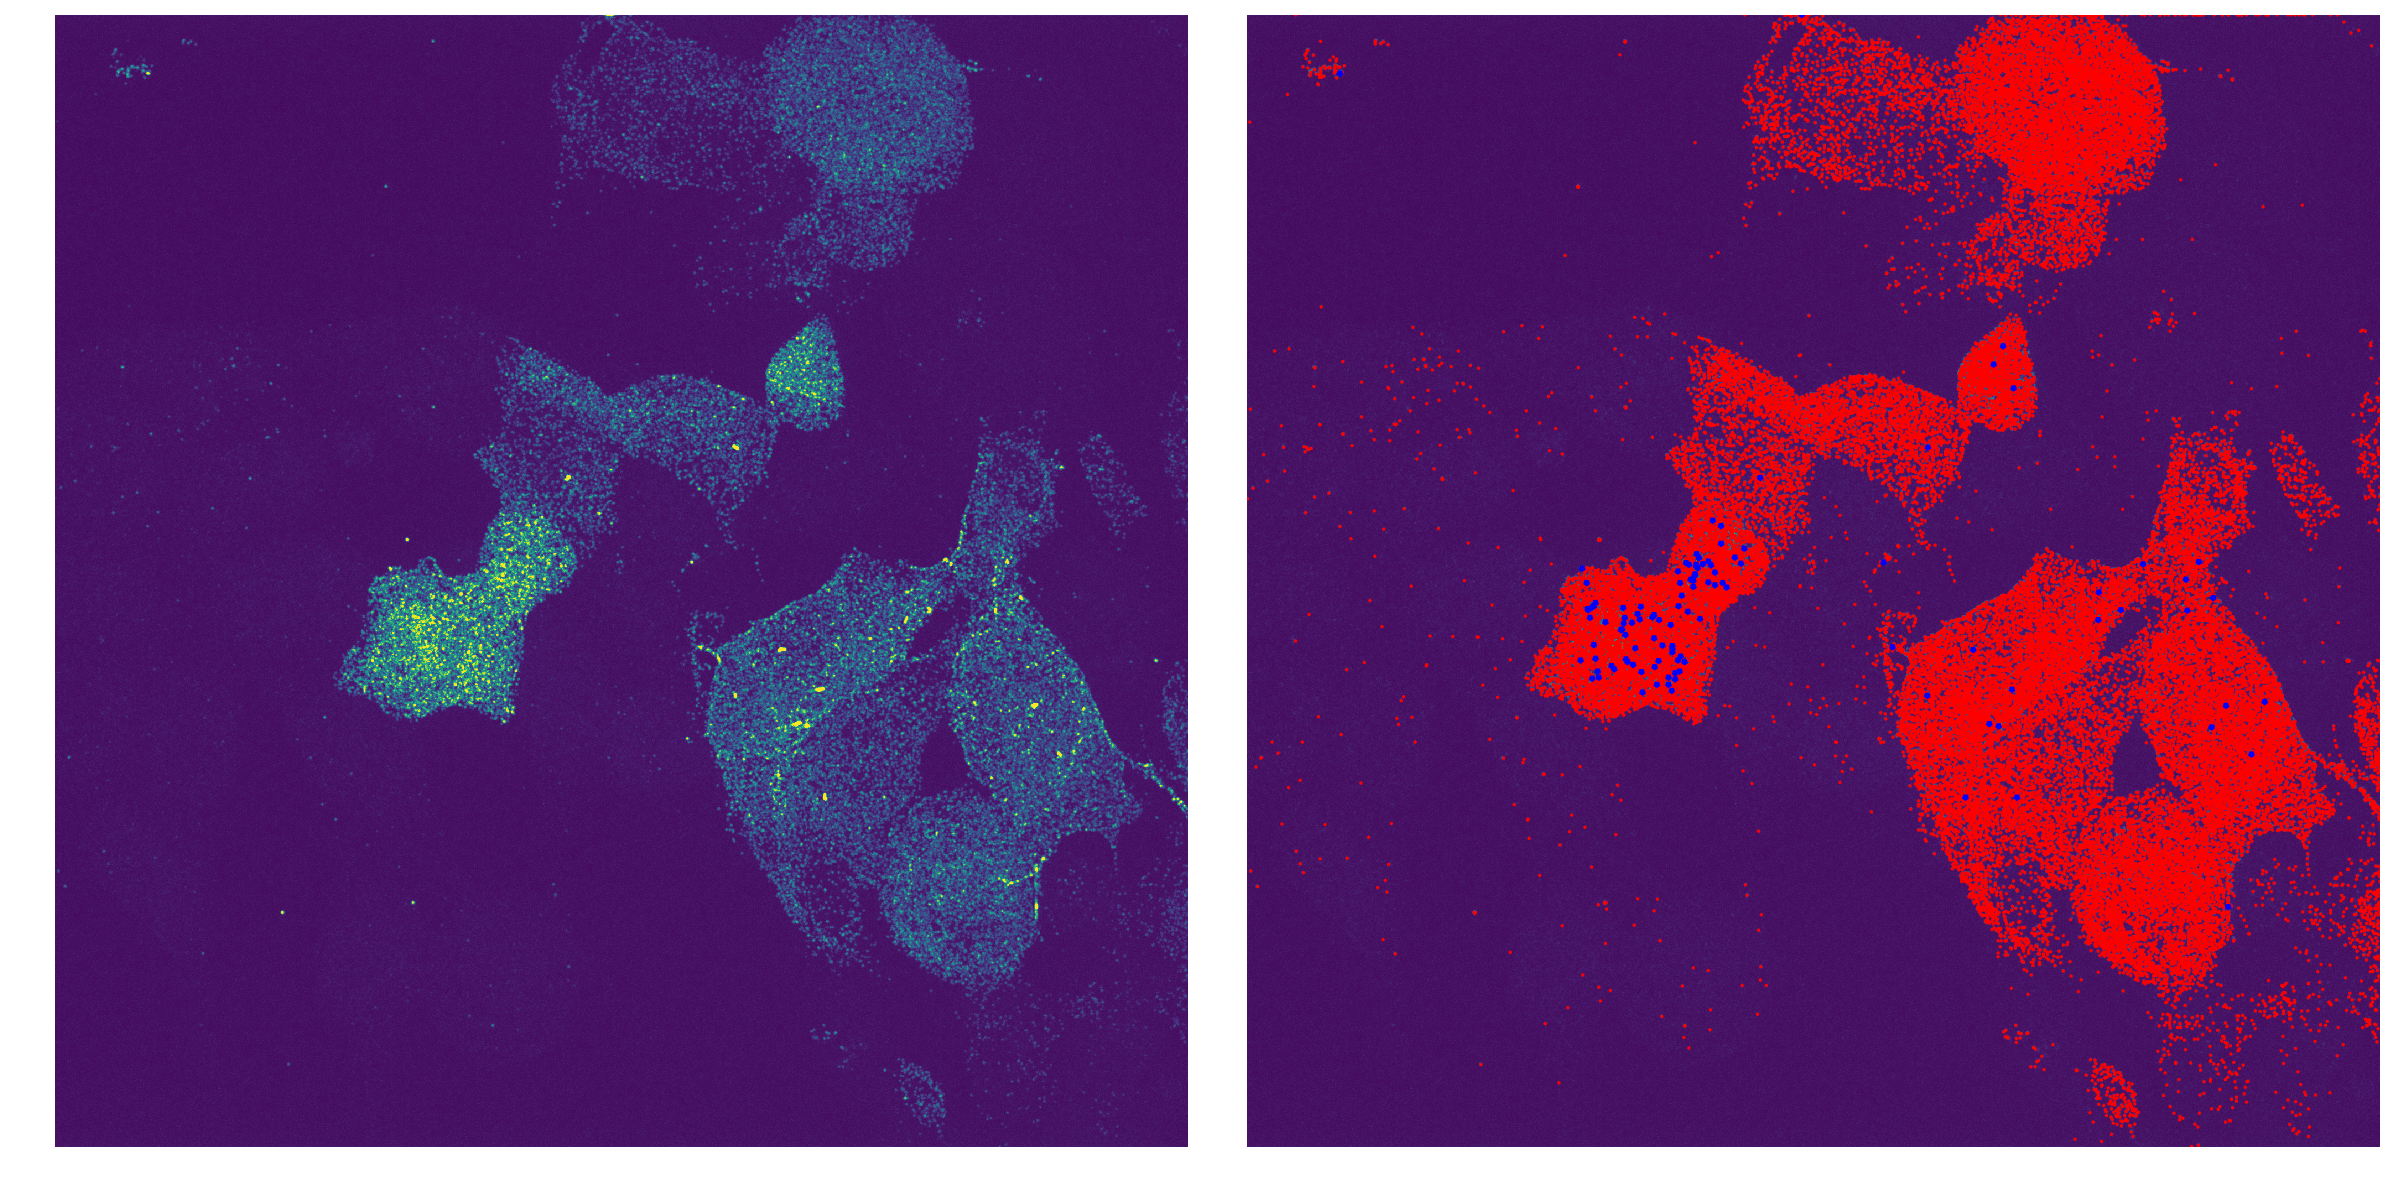

plotting took  49.10083222389221 sec


In [43]:
# separate spots from clusters
radius = 350
nb_min_spots = 10
spots_post_clustering, foci = detection.detect_foci(spots_post_decomposition,
        voxel_size_z, voxel_size_yx, radius, nb_min_spots)

print ("foci separation finished ", time.time() - start_time, "sec")

# extract cell level results
image_contrasted = stack.rescale(rna, channel_to_stretch=0)
image_contrasted = stack.maximum_projection(image_contrasted)
rna_mip = stack.maximum_projection(rna)


print("detected spots after clustering")
print("\r shape: {0}".format(spots_post_clustering.shape))
print("\r dtype: {0}".format(spots_post_clustering.dtype))
print("detected foci")
print("\r shape: {0}".format(foci.shape))
print("\r dtype: {0}".format(foci.dtype))

# Optional plot of spots and foci
start_time = time.time()

(radius_z, radius_yx, radius_yx) = detection.get_radius(voxel_size_z, voxel_size_yx, psf_z, psf_yx)

plot.plot_detection(rna_mip, 
                spots=[spots_post_decomposition, foci[:, :3]], 
                shape=["circle", "polygon"], 
                radius=[radius_yx, radius_yx*2], 
                color=["red", "blue"],
                linewidth=[1, 2], 
                fill=[False, True], 
                framesize=(24, 14), 
                contrast=True)

print ("plotting took ", time.time() - start_time, "sec")

In [34]:
## Export decomposed and clustered spots' xyz coordinates as csv
# spots_post_clustering_df = pd.DataFrame(spots_post_clustering, columns = ['z','x','y','is_in_cluster'])
# spots_post_clustering_df.to_csv('final_output.csv')
np.save('output.npy', spots_post_clustering)


# stack.save_cell_extracted()